## 1. Clone the Git Repo

In [2]:
!git clone https://github.com/hunter3789/VLM.git
%cd VLM
%pwd

Cloning into 'VLM'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 118 (delta 61), reused 38 (delta 20), pack-reused 17 (from 1)
Receiving objects: 100% (118/118), 44.04 MiB | 13.08 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/VLM


'/content/VLM'

## 2. Data pre-processing


[Raw data]
"stn_id": 108
"case": 2024-08-26 03:00:00
"data": [{'pres': 998.2, 'ta': 25.9, 'td': 25.0, 'u': -0.8, 'v': 0.1}, {'pres': 950, 'ta': 24.6, 'td': 20.7, 'gh': 521.5, 'wsd': 1.2, 'vec': 35.5, 'u': -0.7, 'v': -1.0}, {'pres': 925, 'ta': 23.2, 'td': 19.1, 'gh': 755.5, 'wsd': 1.1, 'vec': 44.9, 'u': -0.8, 'v': -0.8}, {'pres': 900, 'ta': 21.4, 'td': 18.1, 'gh': 994.5, 'wsd': 0.4, 'vec': 0.0, 'u': 0.0, 'v': -0.4}, {'pres': 850, 'ta': 17.9, 'td': 14.8, 'gh': 1488.3, 'wsd': 1.3, 'vec': 187.4, 'u': 0.2, 'v': 1.3}, {'pres': 800, 'ta': 15.3, 'td': 10.0, 'gh': 2005.9, 'wsd': 1.6, 'vec': 267.0, 'u': 1.6, 'v': 0.1}, {'pres': 700, 'ta': 9.0, 'td': -2.6, 'gh': 3125.1, 'wsd': 3.8, 'vec': 257.7, 'u': 3.7, 'v': 0.8}, {'pres': 600, 'ta': 3.2, 'td': -41.0, 'gh': 4387.6, 'wsd': 5.8, 'vec': 276.8, 'u': 5.8, 'v': -0.7}, {'pres': 500, 'ta': -4.5, 'td': -13.9, 'gh': 5845.3, 'wsd': 12.7, 'vec': 264.8, 'u': 12.6, 'v': 1.2}, {'pres': 400, 'ta': -13.3, 'td': -17.2, 'gh': 7572.5, 'wsd': 14.9, 'vec': 259.1, 'u

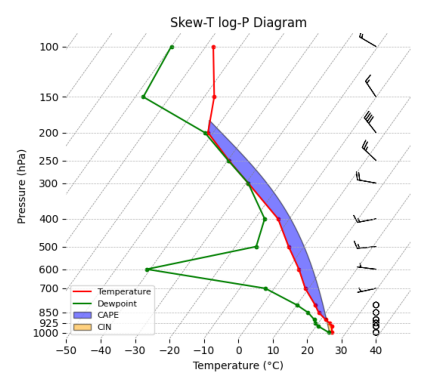


[Prompt generation]
{"system": "You are a weather forecaster analyzing atmospheric soundings shown in a Skew-T log-P diagram
The diagram uses a logarithmic vertical pressure axis (hPa), so pressure layers are not evenly spaced. Use the following visual anchors:
Lower layer (1000-850 hPa): This is located in the bottom quarter of the diagram, close to the surface. It represents the boundary layer where surface temperature, dew point, and CIN typically appear.
Mid layer (850-500 hPa): Appears in the second quarter from the bottom of the plot. This region often contains most of the CAPE and developing updrafts.
Upper layer (500-250 hPa): This is around the middle third of the diagram, despite covering less pressure range. This layer includes the top of convection (EL), cirrus clouds, and upper-level wind shear.
Use the following visual references:
Red line: temperature profile
Green line: dew point temperature
Blue shaded area: CAPE (Convective Available Potential Energy)
Yellow shaded a

In [9]:
from source.tool_call import get_data, process_data, draw_skew, generate_prompt_response_vlm
import matplotlib.pyplot as plt

raw_data = get_data()
print("[Raw data]")
for key, value in raw_data.items():
    if key != 'image':
        print(f'"{key}": {value}')

processed_data = process_data(raw_data)
print("\n[Processed data]")
for key, value in processed_data.items():
    if key not in ['stn_id', 'case', 'rn3h', 'data', 'cape_polygon', 'cin_polygon']:
        print(f'"{key}": {value:.1f}')

# Plot Image
print("\n[Image]")
image = draw_skew(processed_data)
plt.imshow(image)
plt.axis('off')  # Optional: Hide axes
plt.show()

# VLM text generator
print("\n[Prompt generation]")
system_message, user_prompt, response = generate_prompt_response_vlm(processed_data)
print(f'{{"system": "{system_message}",\n')
print(f'"user": "{user_prompt}",\n')
print(f'"assistant": "{response}"}}')

## 3. Load the baseline VLM and the fine-tuned model


In [14]:
from source.base_vlm import BaseVLM

vlm = BaseVLM()

# Load the model with LoRA adapters
from peft import PeftModel

ckpt_path = './model/vlm_curriculum_image_2.2B'
vlm.model = PeftModel.from_pretrained(vlm.model, ckpt_path, local_files_only=True).to(vlm.device)

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/modeling_auto.py:2160: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


## 4. Inference

In [10]:
print("[Inference]")
response = vlm.answer([image], [system_message], [user_prompt], temperature = 0, use_images=True, use_image_path=False)
print(f'"assistant": "{response[0]}"')

[Inference]
"assistant": "The expansive and deep blue region (CAPE) reflects a highly unstable atmosphere, primed for thunderstorm formation.
The blue-shaded area begins low in the atmosphere, indicating that parcels become buoyant with minimal ascent. This favors easy convective initiation.
The CAPE area reaches into the upper levels, suggesting a storm environment with robust vertical development.
The sounding shows potential for cirriform cloud development due to upper-level moisture.
Based on the analysis, the probability of precipitation is low."


## 5. Batched Inference with multiple samples (random choice)

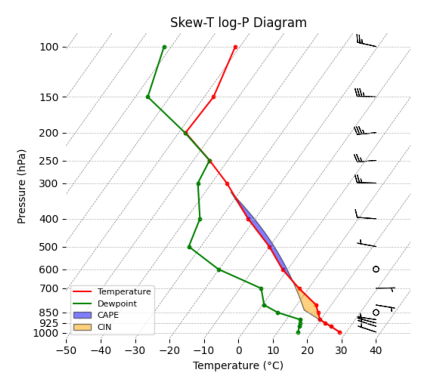

"response (inference)": "Only a thin blue layer (CAPE) appears on the diagram, reflecting weak buoyancy and a limited chance for thunderstorms.
A thick yellow-shaded area (CIN) overlays the lower atmosphere, suggesting a strong cap suppressing vertical motion.
Dry conditions dominate all layers, suggesting limited or no cloud development.
Based on the analysis, the probability of precipitation is low."

"answer (label)": "Moisture is confined to the upper levels, with red and green lines near each other only at high altitudes. Expect high clouds or cirrus formations.
Based on the analysis, the probability of precipitation is low."


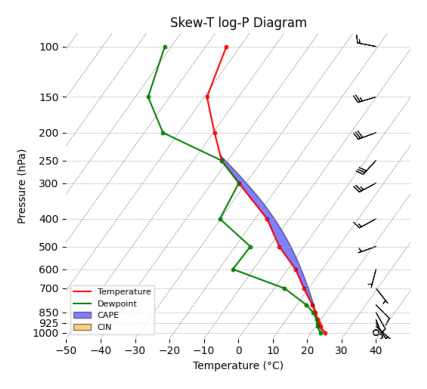

"response (inference)": "Blue shading (CAPE) of moderate depth and width suggests some potential for vertical motion and convective activity.
The low start of the CAPE region reveals minimal inhibition for parcel ascent, encouraging convection even under weak surface forcing.
The blue region extends high into the upper atmosphere, indicating the potential for very tall convective towers and vigorous updrafts.
Moisture trapped at the surface may lead to shallow cloud cover or misty conditions.
Based on the analysis, the probability of precipitation is low."

"answer (label)": "The blue area (CAPE) is noticeable but not expansive, suggesting an environment that can support convection if other triggers align.
The low start of the CAPE region reveals minimal inhibition for parcel ascent, encouraging convection even under weak surface forcing.
The blue region extends high into the upper atmosphere, indicating the potential for very tall convective towers and vigorous updrafts.
Moisture trap

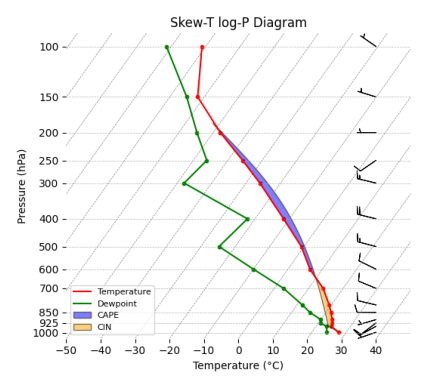

"response (inference)": "Blue shading (CAPE) of moderate depth and width suggests some potential for vertical motion and convective activity.
A heavy yellow band (CIN) suggests a stable lower atmosphere resistant to convective initiation under normal conditions.
The blue-shaded area starts high in the atmosphere, suggesting parcels face strong resistance to ascent and require substantial forcing to become buoyant.
A deep vertical extent of the blue shading points to strong instability, capable of supporting overshooting tops and intense convection.
The Skew-T shows an unsupportive environment for convection, with insufficient moisture throughout.
Based on the analysis, the probability of precipitation is low."

"answer (label)": "A moderately sized blue-shaded region (CAPE) implies moderate instability, which may support thunderstorm development if lifting is present.
A thick yellow-shaded area (CIN) overlays the lower atmosphere, suggesting a strong cap suppressing vertical motion.
Wh

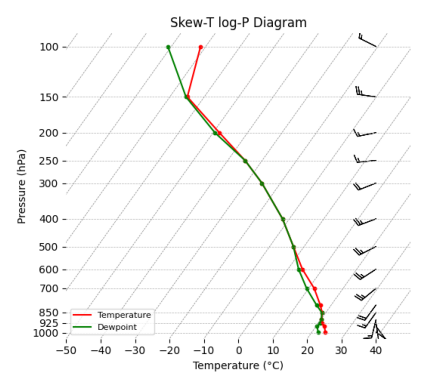

"response (inference)": "Red and green lines track closely through much of the profile, supporting a deep, moist column ideal for rainfall.
Based on the analysis, the probability of precipitation is moderate."

"answer (label)": "Consistent moisture across layers, shown by the tight spacing of temperature and dewpoint lines, suggests high rain potential.
Based on the analysis, the probability of precipitation is very high."


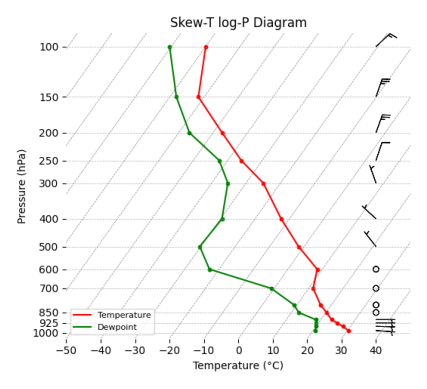

"response (inference)": "The Skew-T shows an unsupportive environment for convection, with insufficient moisture throughout.
Based on the analysis, the probability of precipitation is low."

"answer (label)": "Wide separation of red and green lines throughout the profile indicates a dry atmosphere with little cloud potential.
Based on the analysis, the probability of precipitation is low."


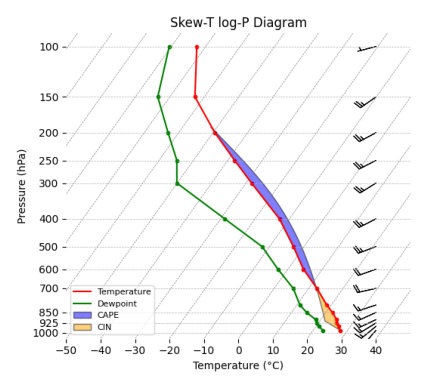

"response (inference)": "A moderately sized blue-shaded region (CAPE) implies moderate instability, which may support thunderstorm development if lifting is present.
The dense yellow layer (CIN) near the surface reflects significant inhibition, likely preventing convection unless strong forcing is present.
The blue-shaded area starts high in the atmosphere, suggesting parcels face strong resistance to ascent and require substantial forcing to become buoyant.
The CAPE area reaches into the upper levels, suggesting a storm environment with robust vertical development.
The wide separation of red and green lines throughout the profile indicates a dry atmosphere with little cloud potential.
Based on the analysis, the probability of precipitation is very high."

"answer (label)": "The blue area (CAPE) is noticeable but not expansive, suggesting an environment that can support convection if other triggers align.
A thick yellow-shaded area (CIN) overlays the lower atmosphere, suggesting a stro

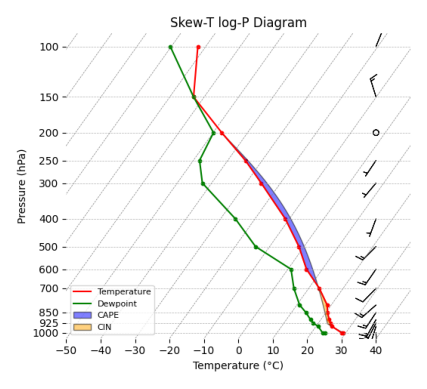

"response (inference)": "The modest extent of the blue region (CAPE) hints at marginal atmospheric instability with potential for weak convective development.
The wide separation of red and green lines throughout the profile indicates a dry atmosphere with little cloud potential.
Based on the analysis, the probability of precipitation is low."

"answer (label)": "Moisture is confined to the upper levels, with red and green lines near each other only at high altitudes. Expect high clouds or cirrus formations.
Based on the analysis, the probability of precipitation is low."


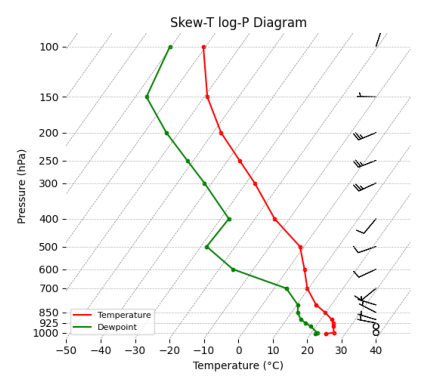

"response (inference)": "The wide separation of red and green lines throughout the profile indicates a dry atmosphere with little cloud potential.
Based on the analysis, the probability of precipitation is low."

"answer (label)": "Wide separation of red and green lines throughout the profile indicates a dry atmosphere with little cloud potential.
Based on the analysis, the probability of precipitation is low."


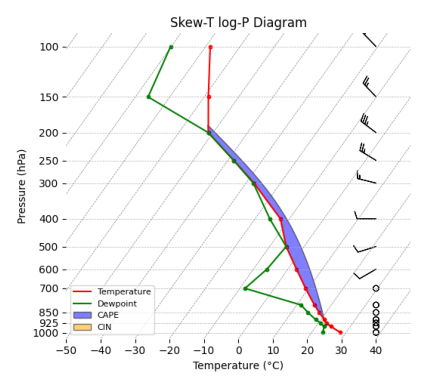

"response (inference)": "A large and vertically extended blue-shaded area (CAPE) indicates strong instability, favoring the development of deep convection.
With the base of the blue region positioned close to the surface, the atmosphere allows parcels to rise freely with little lifting required.
The blue region extends high into the upper atmosphere, indicating the potential for very tall convective towers and vigorous updrafts.
Upper and lower moisture without mid-level support may result in scattered clouds at various levels.
Based on the analysis, the probability of precipitation is low."

"answer (label)": "The expansive and deep blue region (CAPE) reflects a highly unstable atmosphere, primed for thunderstorm formation.
The blue-shaded area begins low in the atmosphere, indicating that parcels become buoyant with minimal ascent. This favors easy convective initiation.
The blue region extends high into the upper atmosphere, indicating the potential for very tall convective towers a

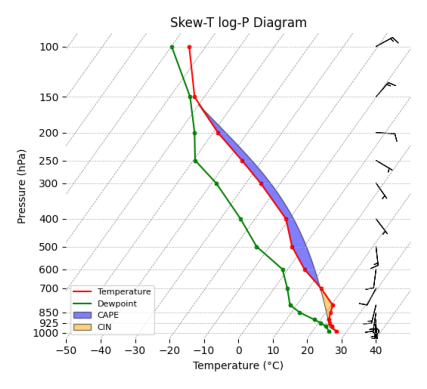

"response (inference)": "A pronounced blue column (CAPE) stretching through much of the troposphere reveals ample energy for vigorous vertical development.
A noticeable yellow-shaded layer (CIN) sits at the base of the sounding, indicating moderate inhibition that could delay or prevent storm development.
When the CAPE region doesn't appear until high levels, it reflects a stable layer below that suppresses spontaneous convection.
The blue region extends high into the upper atmosphere, indicating the potential for very tall convective towers and vigorous updrafts.
The Skew-T shows an unsupportive environment for convection, with insufficient moisture throughout.
Based on the analysis, the probability of precipitation is low."

"answer (label)": "The expansive and deep blue region (CAPE) reflects a highly unstable atmosphere, primed for thunderstorm formation.
A noticeable yellow-shaded layer (CIN) sits at the base of the sounding, indicating moderate inhibition that could delay or prev

In [18]:
images = []
system_messages = []
user_prompts = []
responses = []

for i in range(10):
    raw_data = get_data()
    processed_data = process_data(raw_data)
    image = draw_skew(processed_data)
    system_message, user_prompt, response = generate_prompt_response_vlm(processed_data)
    images.append(image)
    system_messages.append(system_message)
    user_prompts.append(user_prompt)
    responses.append(response)

answers = vlm.answer(images, system_messages, user_prompts, temperature = 0, use_images=True, use_image_path=False)

for image, response, answer in zip(images, responses, answers):
    plt.imshow(image)
    plt.axis('off')  # Optional: Hide axes
    plt.show()

    print(f'"response (inference)": "{response}"\n')
    print(f'"answer (label)": "{answer}"')